In [1]:
!pip install arcticdb

In [1]:
import numpy as np
import pandas as pd
import arcticdb as adb

<center>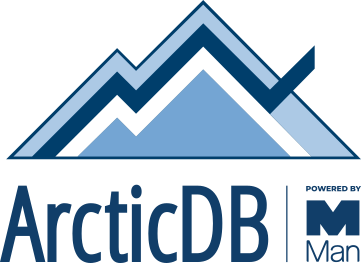
</center>

# ArcticDB Resample Demo

This demo notebook showcases the high-performance resample capability of ArcticDB.

This is what you need to know about it:

* It runs on-the-fly as part of the read
* This makes it much more efficient than Pandas on large datasets
* The usage is similar to the Pandas resample function
* You can apply multiple aggregators to each column
* It can be used for downsampling high frequency data and generating "bar" data (see example 4)

## Setup

In [3]:
# object store
arctic = adb.Arctic("lmdb://arcticdb_resample")

In [4]:
# library
lib = arctic.get_library('resample', create_if_missing=True)

## Create Some Data

* timeseries with 12,000,000 rows and a 1-second index
* int, float, string columns
* write the data into ArcticDB

In [5]:
# data for resampling
index = pd.date_range("1990-01-01", periods=12_000_000, freq="s")
int_data = np.arange(len(index), dtype=np.uint64)
float_data = np.round(np.random.uniform(95., 105., len(index)), 3)
letters = ['a','b','c','d','e','f','g']
floats = [1., 2., 3., 4., 5., np.nan, 7., 8., 9., 10., 11.]
df = pd.DataFrame(
    index=index,
    data={
        "value": int_data,
        "value2": float_data,
        "category": (letters*(len(index)//len(letters) + 1))[:len(index)]
    }
)

In [6]:
# view the first 10 rows of the data
df.head(10)

,value,value2,category
1990-01-01 00:00:00,0,100.547,a
1990-01-01 00:00:01,1,99.925,b
1990-01-01 00:00:02,2,99.832,c
1990-01-01 00:00:03,3,97.498,d
1990-01-01 00:00:04,4,96.337,e
1990-01-01 00:00:05,5,101.679,f
1990-01-01 00:00:06,6,99.933,g
1990-01-01 00:00:07,7,99.457,a
1990-01-01 00:00:08,8,98.141,b
1990-01-01 00:00:09,9,97.707,c


In [7]:
# write the data into ArcticDB
sym = 'resample_test'
lib.write(sym, df)

VersionedItem(symbol='resample_test', library='resample', data=n/a, version=7, metadata=None, host='LMDB(path=/home/nclarke/jupyter/demos/arcticdb_resample)', timestamp=1718803806730682712)

## 1. Simple Resample

* Resample to 1-minute
* Uses different aggregators
* Run in Pandas to compare performance and results 

In [8]:
# frequency and aggregator params
freq1 = '1min'
aggs1 = {'value': 'max', 'value2': 'last', 'category': 'count'}

In [10]:
%%time
# create the resample query and apply it on the read
q1 = adb.QueryBuilder().resample(freq1).agg(aggs1)
resample_df = lib.read(sym, query_builder=q1).data
print(len(resample_df))
resample_df.tail()

200000
CPU times: user 1.1 s, sys: 1.23 s, total: 2.33 s
Wall time: 263 ms


,value,value2,category
1990-05-19 21:15:00,11999759,96.281,60
1990-05-19 21:16:00,11999819,96.431,60
1990-05-19 21:17:00,11999879,97.021,60
1990-05-19 21:18:00,11999939,95.658,60
1990-05-19 21:19:00,11999999,98.561,60


In [11]:
%%time
# read the full data set and resample in Pandas
full_df = lib.read(sym).data
resample_pd_df = full_df.resample(freq1).agg(aggs1)
print(len(resample_pd_df))
resample_pd_df.tail()

200000
CPU times: user 1.11 s, sys: 517 ms, total: 1.63 s
Wall time: 847 ms


,value,value2,category
1990-05-19 21:15:00,11999759,96.281,60
1990-05-19 21:16:00,11999819,96.431,60
1990-05-19 21:17:00,11999879,97.021,60
1990-05-19 21:18:00,11999939,95.658,60
1990-05-19 21:19:00,11999999,98.561,60


## 2. Multiple Aggregators per Column

Similar to NamedAgg in Pandas

In [12]:
q2 = adb.QueryBuilder()
q2 = q2.resample('5min').agg({'value': 'max', 'value2_last': ('value2' ,'last'), 'value2_count': ('value2' ,'count'), 'category': 'first'})

In [13]:
%%time
lib.read(sym, query_builder=q2).data

CPU times: user 896 ms, sys: 1.85 s, total: 2.75 s
Wall time: 217 ms


,value,category,value2_count,value2_last
1990-01-01 00:00:00,299,a,300,104.749
1990-01-01 00:05:00,599,g,300,102.074
1990-01-01 00:10:00,899,f,300,104.503
1990-01-01 00:15:00,1199,e,300,97.385
1990-01-01 00:20:00,1499,d,300,103.044
...,...,...,...,...
1990-05-19 20:55:00,11998799,d,300,102.367
1990-05-19 21:00:00,11999099,c,300,95.750
1990-05-19 21:05:00,11999399,b,300,95.125
1990-05-19 21:10:00,11999699,a,300,104.383


## 3. Processing Pipeline: Chaining Operations

In [14]:
q3 = adb.QueryBuilder()
q3 = q3.resample('2min30s').agg({'value': 'min', 'category': 'first'}).groupby('category').agg({'value': 'mean'})

In [15]:
%%time
lib.read(sym, query_builder=q3).data

CPU times: user 984 ms, sys: 571 ms, total: 1.56 s
Wall time: 100 ms


,value
category,
a,5999700.0
b,5999925.0
d,5999850.0
e,6000075.0
f,5999775.0
g,6000000.0
c,6000150.0


## 4. Example: OHLC (Open High Low Close) Bars

In [16]:
freq_ohlc = '5min'
agg_ohlc = {
    'open': ('value2', 'first'),
    'high': ('value2', 'max'),
    'low': ('value2', 'min'),
    'close': ('value2', 'last')
}
q_ohlc = adb.QueryBuilder().resample(freq_ohlc).agg(agg_ohlc)

In [17]:
%%time
ohlc_bars = lib.read(sym, query_builder=q_ohlc).data

CPU times: user 1.32 s, sys: 501 ms, total: 1.82 s
Wall time: 114 ms


In [18]:
ohlc_bars.head()

,close,low,high,open
1990-01-01 00:00:00,104.749,95.014,104.954,100.547
1990-01-01 00:05:00,102.074,95.009,104.943,96.765
1990-01-01 00:10:00,104.503,95.025,104.995,99.264
1990-01-01 00:15:00,97.385,95.010,104.974,96.309
1990-01-01 00:20:00,103.044,95.006,104.962,98.319


## Conclusion

We have demonstrated the following about the ArcticDB resample feature:

* Easy to use, especially if you already resample in Pandas
* Very high performance - in particular much faster than reading all the data then resampling in Pandas
* Can be combined with other query functions to build processing pipelines
* Can be used to generate timeseries bars